In [4]:
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery, bigquery_storage
import matplotlib.pyplot as plt
import seaborn as sns

# Set up authentication for BigQuery
CREDENTIALS_PATH = r"C:\Users\eddie\OneDrive\code\magician\config\cloud_credentials.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = CREDENTIALS_PATH

# Initialize BigQuery Client
client = bigquery.Client()
bqstorage_client = bigquery_storage.BigQueryReadClient()



In [5]:
PROJECT_ID = "cloud4marketing-281206"
DATASET_ID = "crypto_price"
CLEANED_TABLE = f"{PROJECT_ID}.{DATASET_ID}.cleaned_data"

query = f"""
    SELECT asset, timestamp, open_price, high_price, low_price, close_price, volume
    FROM `{CLEANED_TABLE}`
    ORDER BY asset, timestamp
"""
df = client.query(query).to_dataframe(bqstorage_client=bqstorage_client)

# Convert timestamp to datetime for better analysis
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Preview the data
df.head()



,asset,timestamp,open_price,high_price,low_price,close_price,volume
0,AAVE,2023-12-20 13:00:00+00:00,0.092791,0.092906,0.099407,0.095589,3651.933
1,AAVE,2023-12-20 14:00:00+00:00,0.098377,0.096435,0.103519,0.094695,5502.326
2,AAVE,2023-12-20 15:00:00+00:00,0.097818,0.094502,0.102703,0.094233,2942.857
3,AAVE,2023-12-20 16:00:00+00:00,0.097074,0.091924,0.099689,0.092231,2533.797
4,AAVE,2023-12-20 17:00:00+00:00,0.094994,0.091986,0.100819,0.093617,2319.105


In [6]:
df.describe()


,open_price,high_price,low_price,close_price,volume
count,930353.000000,930353.000000,930353.000000,930353.000000,9.303530e+05
mean,0.296870,0.280280,0.319130,0.297382,7.492274e+08
std,0.213016,0.211139,0.227262,0.213013,2.199457e+10
min,0.000000,0.000000,0.000000,0.000000,1.000000e-06
25%,0.121434,0.104769,0.130704,0.121902,1.094829e+03
50%,0.248470,0.229921,0.266349,0.249096,1.352380e+04
75%,0.427720,0.407866,0.455869,0.428754,1.282250e+05
max,1.000000,1.000000,1.000000,1.000000,4.671313e+12


In [7]:
df.isnull().sum()


asset          0
timestamp      0
open_price     0
high_price     0
low_price      0
close_price    0
volume         0
dtype: int64

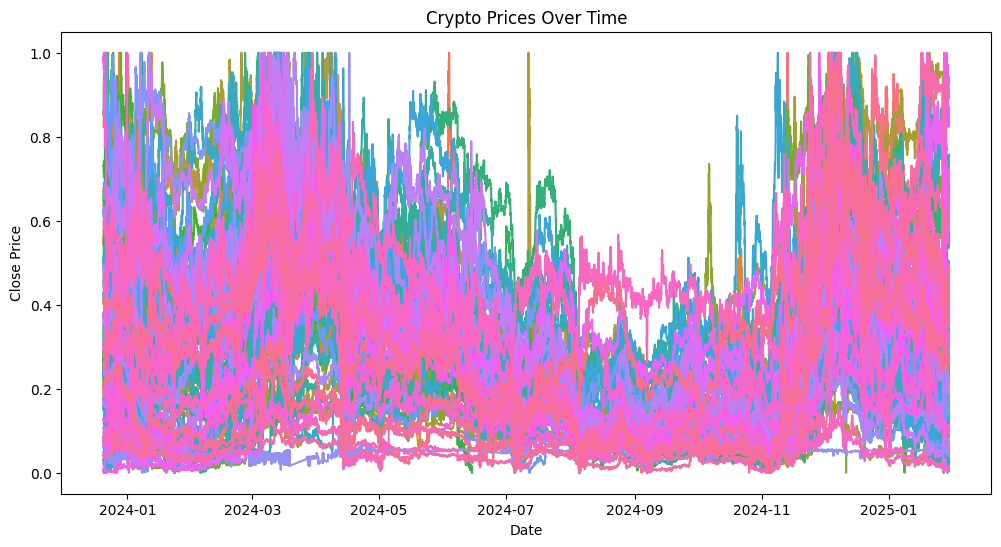

In [9]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="timestamp", y="close_price", hue="asset", legend=False)
plt.title("Crypto Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


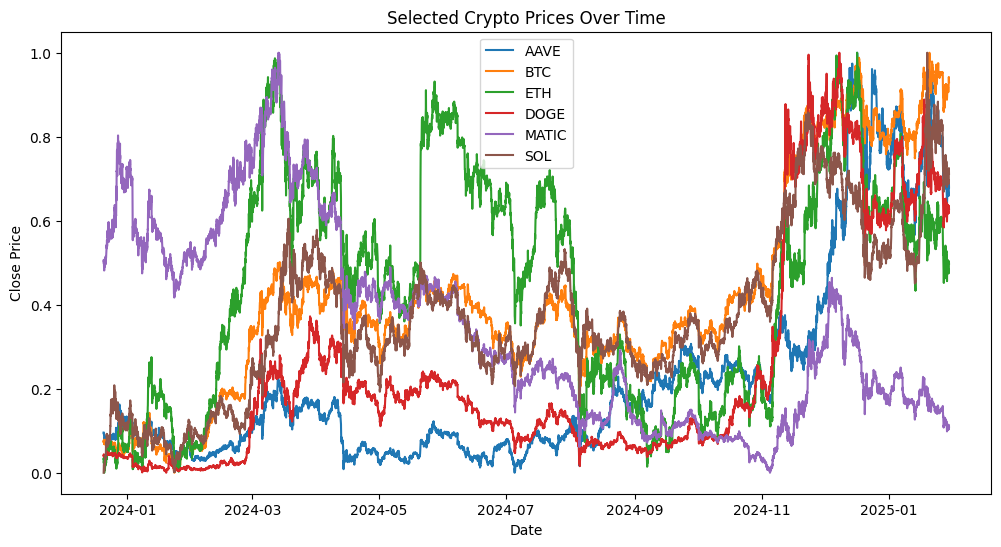

In [15]:
# Select a few example assets
assets_to_explore = ["AAVE", "BTC", "ETH", "DOGE", "MATIC", "SOL"]  # Replace with any assets in your dataset

plt.figure(figsize=(12,6))
for asset in assets_to_explore:
    subset = df[df["asset"] == asset]
    plt.plot(subset["timestamp"], subset["close_price"], label=asset)

plt.title("Selected Crypto Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()



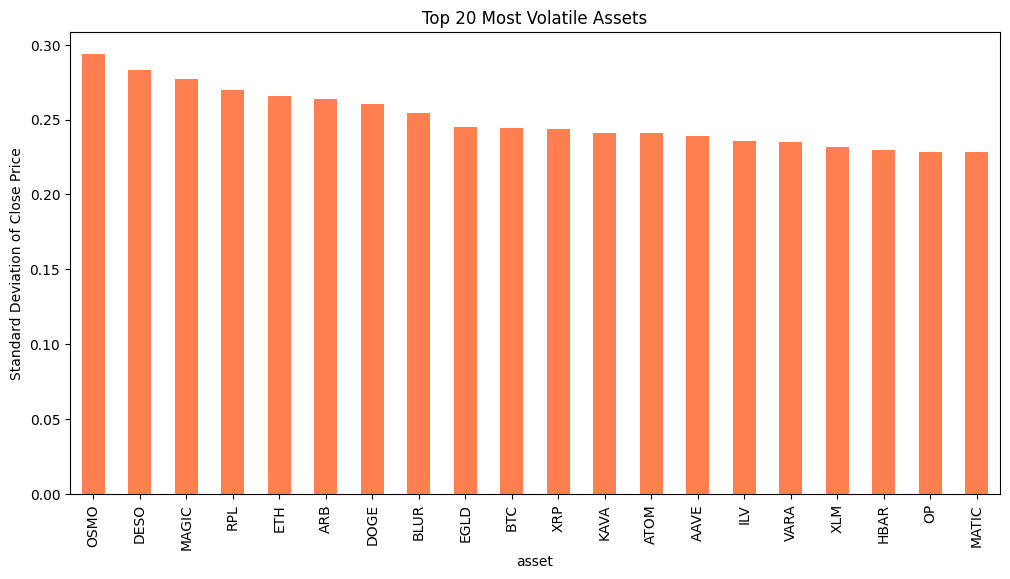

In [11]:
# Calculate rolling standard deviation (volatility)
volatility = df.groupby("asset")["close_price"].std().sort_values(ascending=False)

# Plot the most volatile assets
plt.figure(figsize=(12, 6))
volatility.head(20).plot(kind="bar", color="coral")
plt.title("Top 20 Most Volatile Assets")
plt.ylabel("Standard Deviation of Close Price")
plt.xticks(rotation=90)
plt.show()



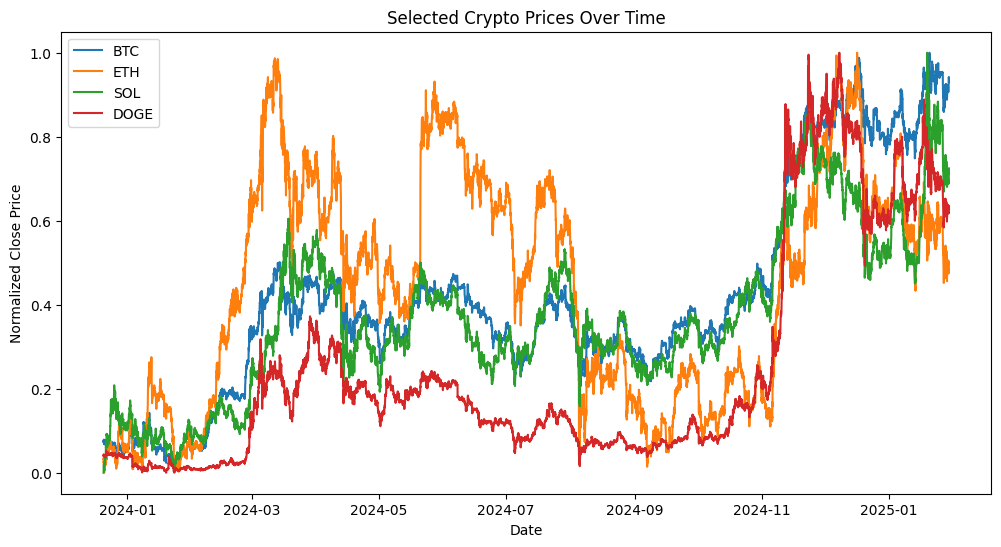

In [14]:
# Select a few example cryptocurrencies
cryptos_to_explore = ["BTC", "ETH", "SOL", "DOGE"]  # Replace with any cryptos in your dataset

plt.figure(figsize=(12,6))
for crypto in cryptos_to_explore:
    subset = df[df["asset"] == crypto]
    plt.plot(subset["timestamp"], subset["close_price"], label=crypto)

plt.title("Selected Crypto Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.show()


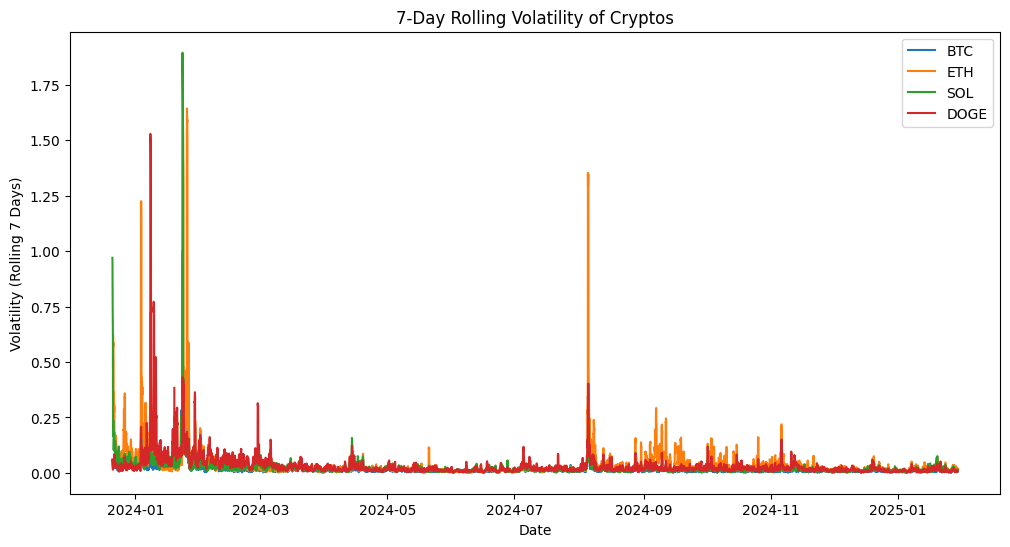

In [16]:
# Calculate volatility using rolling standard deviation (7-day window)
df["volatility"] = df.groupby("asset")["close_price"].transform(lambda x: x.pct_change().rolling(7).std())

# Plot volatility of major cryptos
plt.figure(figsize=(12,6))
for crypto in cryptos_to_explore:
    subset = df[df["asset"] == crypto]
    plt.plot(subset["timestamp"], subset["volatility"], label=crypto)

plt.title("7-Day Rolling Volatility of Cryptos")
plt.xlabel("Date")
plt.ylabel("Volatility (Rolling 7 Days)")
plt.legend()
plt.show()


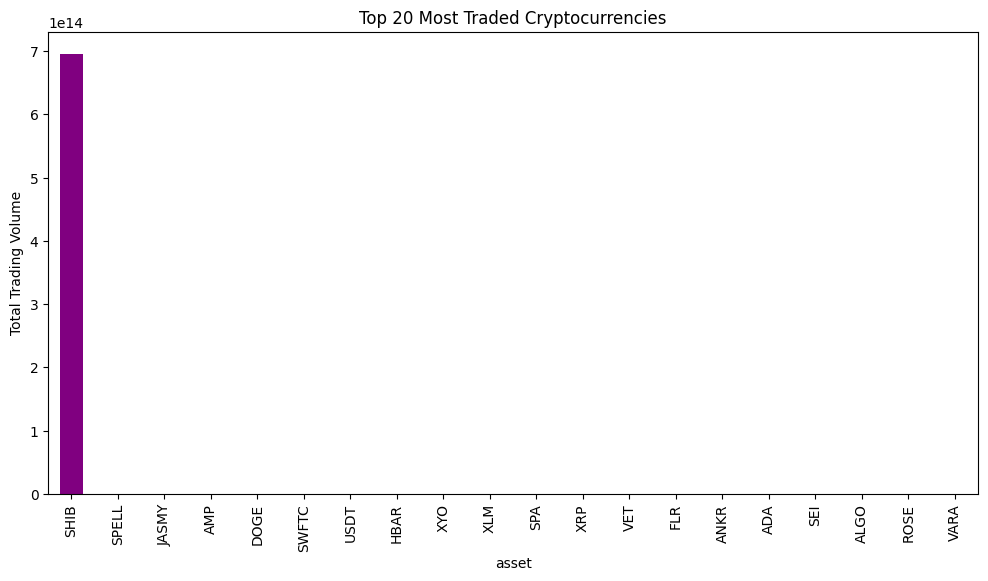

In [17]:
# Aggregate total volume traded per crypto
top_traded_cryptos = df.groupby("asset")["volume"].sum().sort_values(ascending=False)

# Plot the top 20 traded cryptos
plt.figure(figsize=(12,6))
top_traded_cryptos.head(20).plot(kind="bar", color="purple")
plt.title("Top 20 Most Traded Cryptocurrencies")
plt.ylabel("Total Trading Volume")
plt.xticks(rotation=90)
plt.show()


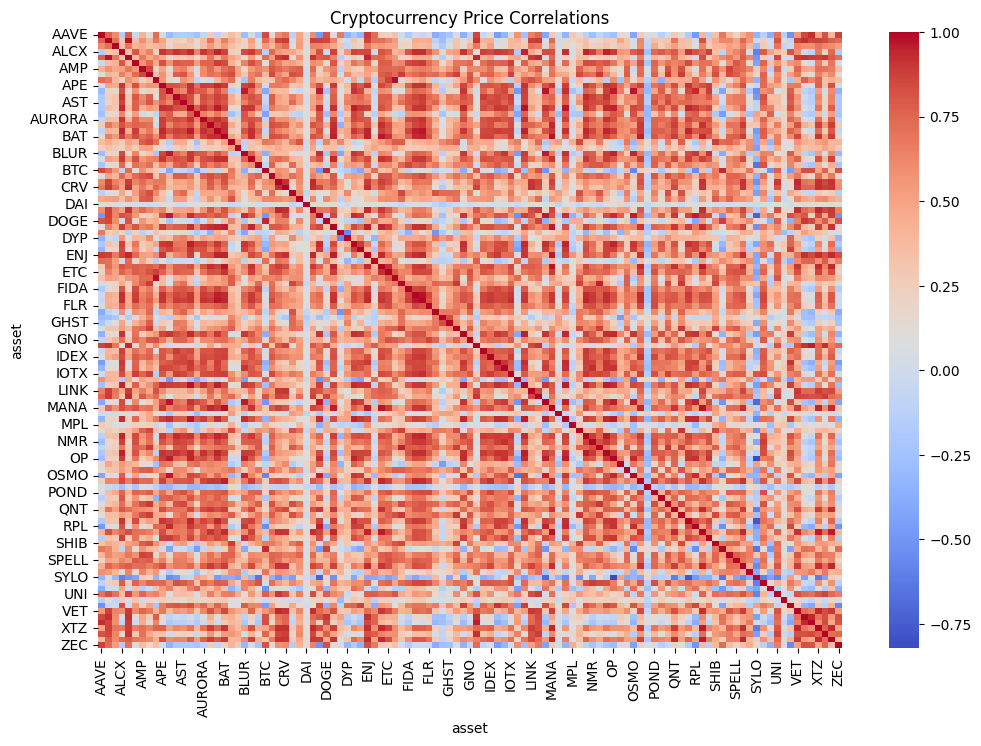

In [18]:
import seaborn as sns

# Pivot DataFrame to get assets as columns
pivot_df = df.pivot(index="timestamp", columns="asset", values="close_price")

# Compute correlation between cryptos
crypto_corr = pivot_df.corr()

# Visualize with heatmap
plt.figure(figsize=(12,8))
sns.heatmap(crypto_corr, cmap="coolwarm", annot=False)
plt.title("Cryptocurrency Price Correlations")
plt.show()


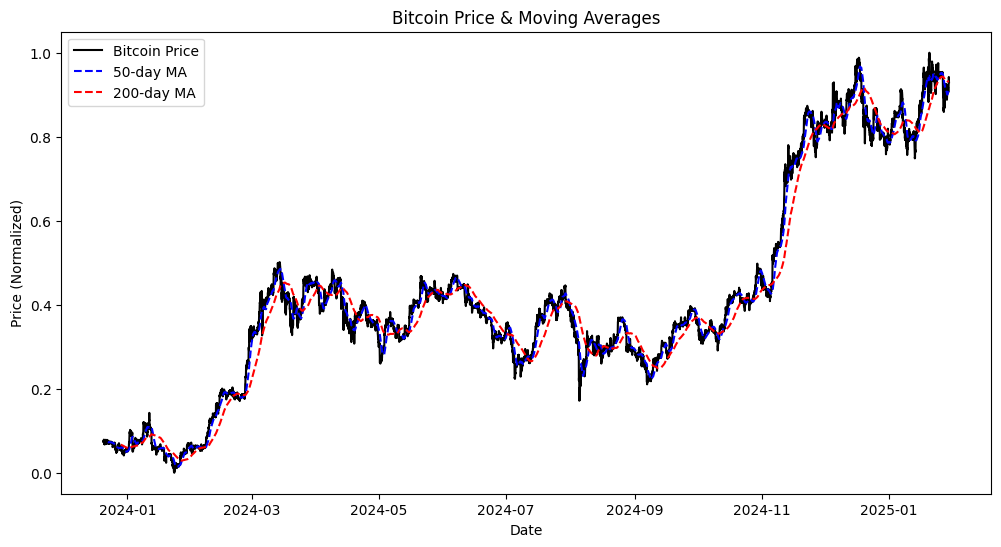

In [19]:
# Calculate 50-day and 200-day moving averages (trend indicator)
df["MA50"] = df.groupby("asset")["close_price"].transform(lambda x: x.rolling(50).mean())
df["MA200"] = df.groupby("asset")["close_price"].transform(lambda x: x.rolling(200).mean())

# Plot trend for Bitcoin
btc = df[df["asset"] == "BTC"]
plt.figure(figsize=(12,6))
plt.plot(btc["timestamp"], btc["close_price"], label="Bitcoin Price", color="black")
plt.plot(btc["timestamp"], btc["MA50"], label="50-day MA", color="blue", linestyle="dashed")
plt.plot(btc["timestamp"], btc["MA200"], label="200-day MA", color="red", linestyle="dashed")

plt.title("Bitcoin Price & Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (Normalized)")
plt.legend()
plt.show()


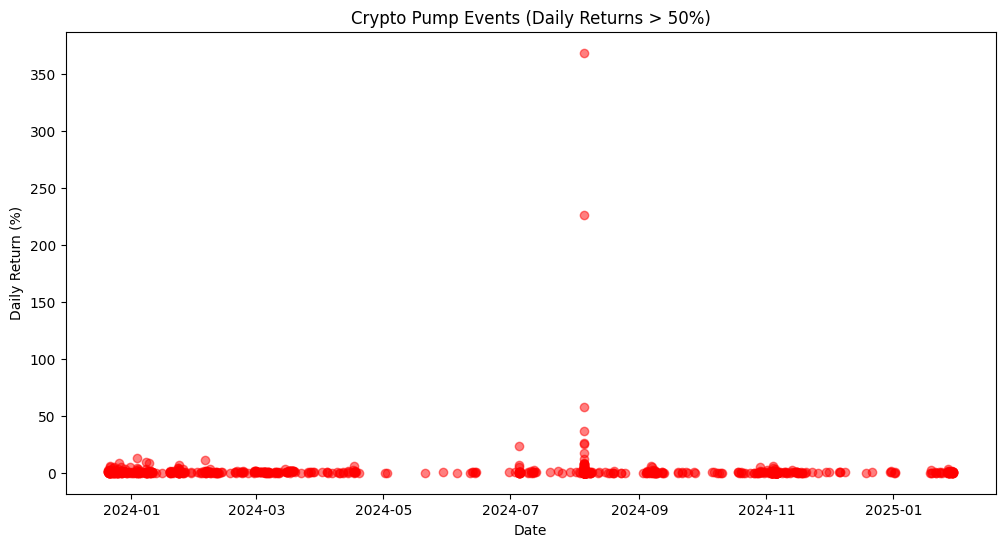

In [20]:
# Find percentage change over 1 day
df["daily_return"] = df.groupby("asset")["close_price"].pct_change()

# Flag potential pumps (returns > 50%)
df["pump_flag"] = df["daily_return"] > 0.50

# Plot examples of major pumps
pumped_cryptos = df[df["pump_flag"] == True]
plt.figure(figsize=(12,6))
plt.scatter(pumped_cryptos["timestamp"], pumped_cryptos["daily_return"], color="red", alpha=0.5)

plt.title("Crypto Pump Events (Daily Returns > 50%)")
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.show()



In [1]:
import pandas as pd
from google.cloud import bigquery

# Authenticate
PROJECT_ID = "cloud4marketing-281206"
DATASET_ID = "crypto_price"
TECHNICALS_TABLE = f"{PROJECT_ID}.{DATASET_ID}.technical_indicators"

client = bigquery.Client()

# Load Data
query = f"SELECT * FROM `{TECHNICALS_TABLE}` ORDER BY asset, timestamp"
df_indicators = client.query(query).to_dataframe()

# Preview
df_indicators.head()



DefaultCredentialsError: File C:/path/to/your-service-account.json was not found.

In [4]:
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery, bigquery_storage
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Set up authentication for BigQuery
CREDENTIALS_PATH = r"C:\Users\eddie\OneDrive\code\magician\config\cloud_credentials.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = CREDENTIALS_PATH

# ✅ Initialize BigQuery Client
client = bigquery.Client()
bqstorage_client = bigquery_storage.BigQueryReadClient()

# ✅ Load Technical Indicators Table
PROJECT_ID = "cloud4marketing-281206"
DATASET_ID = "crypto_price"
TECHNICALS_TABLE = f"{PROJECT_ID}.{DATASET_ID}.technical_indicators"

query = f"SELECT * FROM `{TECHNICALS_TABLE}` ORDER BY asset, timestamp"
df_indicators = client.query(query).to_dataframe(bqstorage_client=bqstorage_client)

# ✅ Preview Data
df_indicators.head()


,asset,timestamp,open_price,high_price,low_price,close_price,volume,ema_20,ema_50,rsi_14,bollinger_mid,bollinger_std,bollinger_upper,bollinger_lower,macd,macd_signal,mfi_14,z_score
0,AAVE,2024-07-31 05:00:00+00:00,105.02,105.10,104.36,104.60,189.991,105.213772,104.797906,51.531729,105.2215,1.089303,107.400107,103.042893,0.350769,0.278305,58.043653,-0.570548
1,AAVE,2024-07-31 06:00:00+00:00,105.64,106.23,105.63,106.17,367.329,105.304842,104.851714,54.470709,105.3190,1.082190,107.483381,103.154619,0.382922,0.299228,36.845513,0.786368
2,AAVE,2024-07-31 07:00:00+00:00,106.67,107.16,106.66,106.82,257.212,105.449142,104.928901,63.841202,105.3395,1.107532,107.554563,103.124437,0.455601,0.330503,65.078648,1.336757
3,AAVE,2024-07-31 08:00:00+00:00,106.99,107.13,106.65,107.13,52.049,105.609224,105.015219,66.173362,105.3780,1.157145,107.692291,103.063709,0.532081,0.370819,66.006752,1.514071
4,AAVE,2024-07-31 09:00:00+00:00,107.46,107.46,107.12,107.17,222.734,105.757869,105.099720,66.737288,105.4295,1.214350,107.858201,103.000799,0.589128,0.414480,68.485187,1.433276


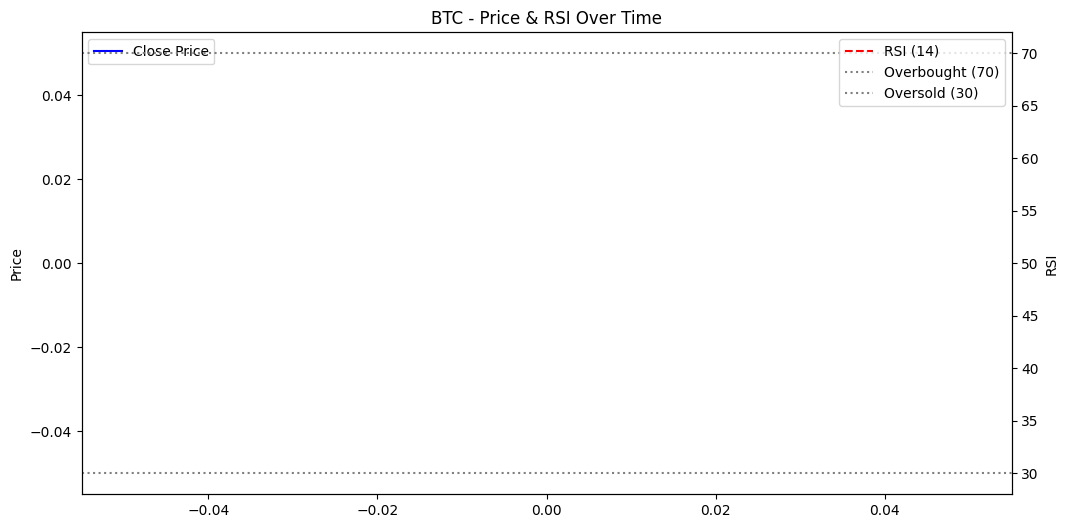

In [5]:
import matplotlib.pyplot as plt

# Select an asset to visualize
asset_to_plot = "BTC"

# Filter dataset for this asset
df_sample = df_indicators[df_indicators["asset"] == asset_to_plot].copy()

# Plot Close Price and RSI together
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_title(f"{asset_to_plot} - Price & RSI Over Time")
ax1.plot(df_sample["timestamp"], df_sample["close_price"], color="blue", label="Close Price")
ax1.set_ylabel("Price")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(df_sample["timestamp"], df_sample["rsi_14"], color="red", linestyle="dashed", label="RSI (14)")
ax2.axhline(70, color="gray", linestyle="dotted", label="Overbought (70)")
ax2.axhline(30, color="gray", linestyle="dotted", label="Oversold (30)")
ax2.set_ylabel("RSI")
ax2.legend(loc="upper right")

plt.show()


KeyError: 'atr'

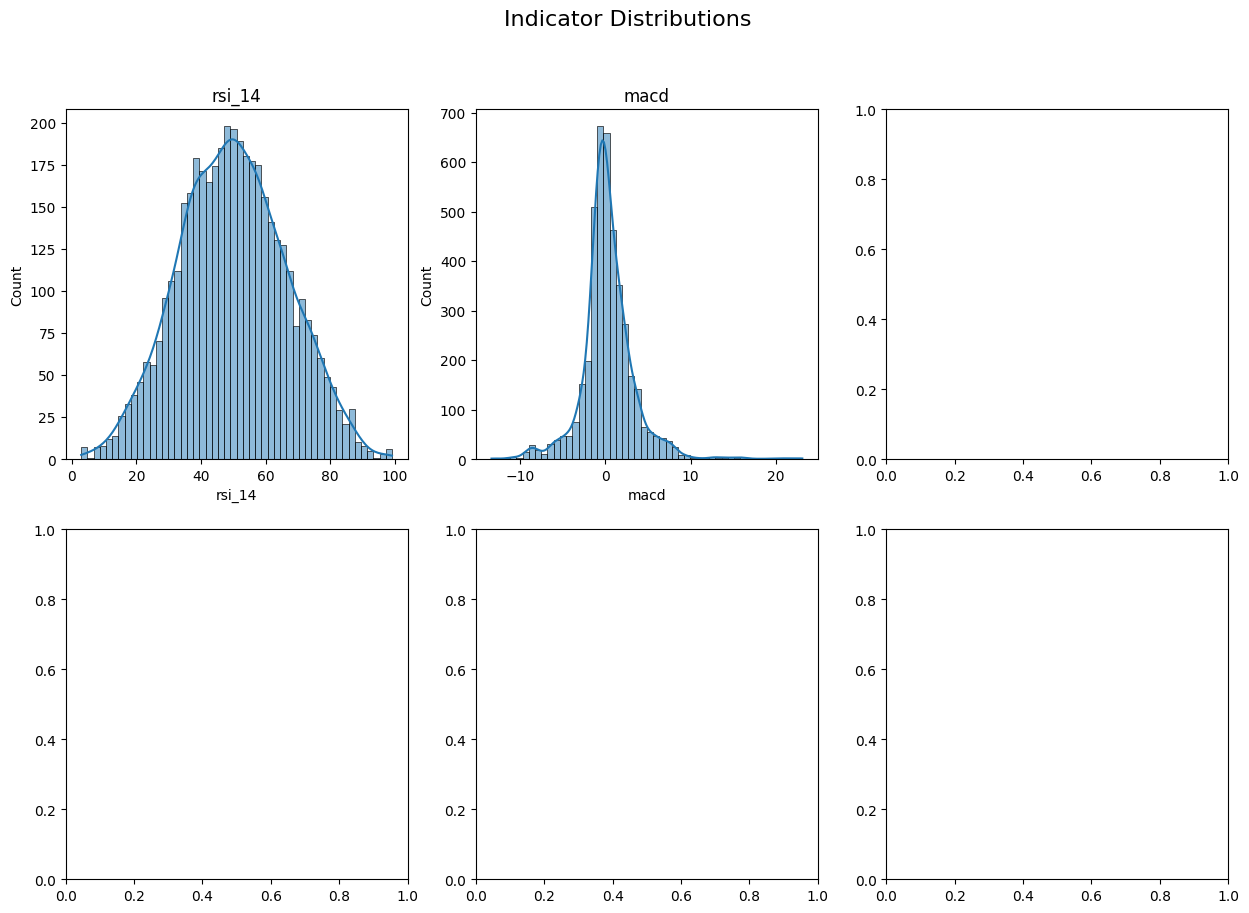

In [6]:
import seaborn as sns

# List of indicators to check
indicators_to_check = ["rsi_14", "macd", "atr", "bollinger_upper", "bollinger_lower"]

# Plot histograms
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle("Indicator Distributions", fontsize=16)

for i, indicator in enumerate(indicators_to_check):
    ax = axes[i//3, i%3]
    sns.histplot(df_indicators[indicator].dropna(), bins=50, kde=True, ax=ax)
    ax.set_title(indicator)

plt.tight_layout()
plt.show()
